In [ ]:
# Downloading all codes & dependencies
!git clone https://github.com/ZhengPeng7/BiRefNet.git
!pip uninstall -q torchaudio torchdata torchtext -y
!pip install -q -r BiRefNet/requirements.txt
!pip install -q -U gdown
# Download a sample image in very high resolution
!gdown 1DGBe63XrwwSutS84FrrrjDga3BiuQsRc
!mkdir images_todo
!mv Helicopter-HR.jpg images_todo/
# Download weights locally
!wget https://github.com/ZhengPeng7/BiRefNet/releases/download/v1/BiRefNet-general-epoch_244.pth
%cd BiRefNet

Cloning into 'BiRefNet'...
remote: Enumerating objects: 1339, done.
remote: Counting objects: 100% (705/705), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 1339 (delta 569), reused 595 (delta 488), pack-reused 634 (from 1)
Receiving objects: 100% (1339/1339), 5.43 MiB | 21.98 MiB/s, done.
Resolving deltas: 100% (914/914), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 548.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.7 MB/s eta 0:00:00
Downloading.

In [ ]:
# Imports
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display

from models.birefnet import BiRefNet


# # Option 1: loading BiRefNet with weights:
from transformers import AutoModelForImageSegmentation
birefnet = AutoModelForImageSegmentation.from_pretrained('zhengpeng7/BiRefNet', trust_remote_code=True)

# # Option-2: loading weights with BiReNet codes:
# birefnet = BiRefNet.from_pretrained('zhengpeng7/BiRefNet')

# # Option-3: Loading model and weights from local disk:
# from utils import check_state_dict

# birefnet = BiRefNet(bb_pretrained=False)
# state_dict = torch.load('../BiRefNet-general-epoch_244.pth', map_location='cpu')
# state_dict = check_state_dict(state_dict)
# birefnet.load_state_dict(state_dict)


# Load Model
device = 'cuda'
torch.set_float32_matmul_precision(['high', 'highest'][0])

birefnet.to(device)
birefnet.eval()
print('BiRefNet is ready to use.')

# Input Data
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

BiRefNet is ready to use.


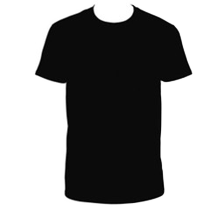

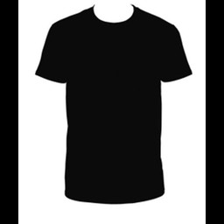

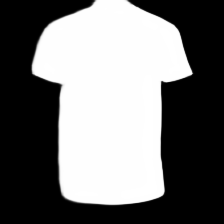

In [ ]:
import requests
from io import BytesIO


image_url = "/content/black_3.jpg"
# response = requests.get(image_url)
# image_data = BytesIO(image_url.content)
image = Image.open(image_url)
input_images = transform_image(image).unsqueeze(0).to('cuda')

# Prediction
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# Show Results
pred_pil = transforms.ToPILImage()(pred)
# Scale proportionally with max length to 1024 for faster showing
scale_ratio = 224 / max(image.size)
scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))
image_masked = image.resize((224, 224))
image_masked.putalpha(pred_pil)
display(image_masked.resize(scaled_size))
display(image.resize(scaled_size))
display(pred_pil.resize(scaled_size))

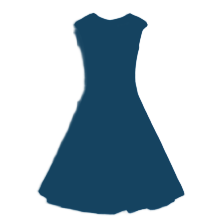

Saved the masked and colored result image at /content/masked_colored_result-91.png


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Assuming birefnet is already loaded and transform_image is defined
# image_url = "https://example.com/image.jpg"  # Replace with a real URL if using requests

# Load the image
image_path = "/content/91.jpg"
image = Image.open(image_path).convert("RGB")  # Convert to RGB

# Transform the image as required by the model
input_images = transform_image(image).unsqueeze(0).to('cuda')

# Prediction
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# Convert prediction mask to a PIL image and resize it
pred_pil = transforms.ToPILImage()(pred)

# Resize the mask and original image to match
image_masked = image.resize((224, 224)).convert("RGBA")  # Convert back to RGBA for transparency
pred_pil = pred_pil.resize((224, 224))

# Apply the mask as an alpha channel
image_masked.putalpha(pred_pil)

# Define the color to apply on the masked area
masked_color = (21, 67, 96)
# 171, 61, 37  # Red with full opacity
# 21, 67, 96
# Create a colored overlay using the mask
colored_overlay = Image.new("RGBA", image_masked.size, masked_color)
colored_overlay.putalpha(pred_pil)

# Composite the colored overlay on the original image using the mask
result_image = Image.alpha_composite(image_masked, colored_overlay)

# Resize for display purposes
scale_ratio = 224 / max(image.size)
scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))

# Display the result with the colored mask
display(result_image.resize(scaled_size))

# Optional: Save the result
output_path = "/content/masked_colored_result-91.png"
result_image.save(output_path, "PNG")
print(f"Saved the masked and colored result image at {output_path}")


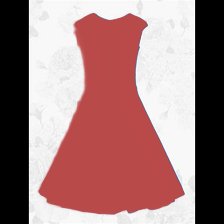

Saved the blended image with preserved texture at /content/colored_with_texture_preserved.png


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Assuming birefnet is already loaded and transform_image is defined
# image_url = "https://example.com/image.jpg"  # Replace with a real URL if using requests

# Load the image and convert to RGB for model processing
image_path = "/content/91.jpg"
image = Image.open(image_path).convert("RGB")  # Convert to RGB

# Transform the image as required by the model
input_images = transform_image(image).unsqueeze(0).to('cuda')

# Prediction
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# Convert prediction mask to a PIL image and resize it
pred_pil = transforms.ToPILImage()(pred)

# Resize the mask and original image to match, convert to RGBA for transparency
image_masked = image.resize((224, 224)).convert("RGBA")
pred_pil = pred_pil.resize((224, 224))

# Define the color you want to apply and convert it to RGBA
new_color = (186, 74, 74, 0)  # Semi-transparent new color (adjust alpha to control blending)

# Create an overlay with the desired color and apply the mask for transparency
color_overlay = Image.new("RGBA", image_masked.size, new_color)
color_overlay.putalpha(pred_pil)

# Composite the new color overlay with the original image, keeping the texture
blended_image = Image.alpha_composite(image_masked, color_overlay)

# Save and display the final result
output_path = "/content/colored_with_texture_preserved.png"
blended_image.save(output_path, "PNG")
display(blended_image)
print(f"Saved the blended image with preserved texture at {output_path}")


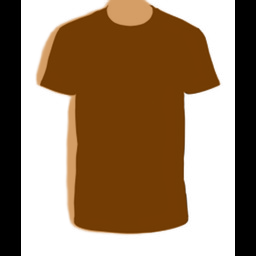

Saved the blended image with preserved texture at /content/t-shirt.png


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

# Assuming birefnet is already loaded and transform_image is defined

# Load the image and convert to RGB for model processing
image_path = "/content/black_3.jpg"
image = Image.open(image_path).convert("RGB")  # Convert to RGB

# Transform the image as required by the model
input_images = transform_image(image).unsqueeze(0).to('cuda')

# Prediction
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# Convert prediction mask to a PIL image and resize it
pred_pil = transforms.ToPILImage()(pred)
pred_pil = pred_pil.resize(image.size)

# Convert images to numpy arrays for OpenCV processing
original_np = np.array(image)
mask_np = np.array(pred_pil)

# Create a color overlay with the desired color and same size as the original image
overlay_color = (186, 94, 0)  # Desired color (e.g., red)
overlay_np = np.full_like(original_np, overlay_color)

# Normalize mask to range [0, 1] for blending
mask_np = mask_np / 255.0

# Blend the color overlay with the original image using the mask
blended_np = (overlay_np * mask_np[..., None] * 0.6 + original_np * (1 - mask_np[..., None] * 0.6)).astype(np.uint8)

# Convert the blended result back to a PIL image
blended_image = Image.fromarray(blended_np)

# Save and display the final result
output_path = "/content/t-shirt.png"
blended_image.save(output_path, "PNG")
display(blended_image)
print(f"Saved the blended image with preserved texture at {output_path}")
